Monte Carlo Simulation Results:
        SKU  Discount  Revenue_BAU  Revenue_Event
0     SKU_1      0.00    9264.0000    23160.00000
1     SKU_1      0.05   10120.9200    25302.30000
2     SKU_1      0.10   10838.8800    27097.20000
3     SKU_1      0.15   11417.8800    28544.70000
4     SKU_1      0.20    9486.3360    23715.84000
...     ...       ...          ...            ...
1675  SKU_4      0.10    8878.8960    10654.67520
1676  SKU_4      0.15    7950.2166     9540.25992
1677  SKU_4      0.20    7770.9312     9325.11744
1678  SKU_4      0.25    7470.2250     8964.27000
1679  SKU_4      0.30    7065.1728     8478.20736

[1680 rows x 4 columns]


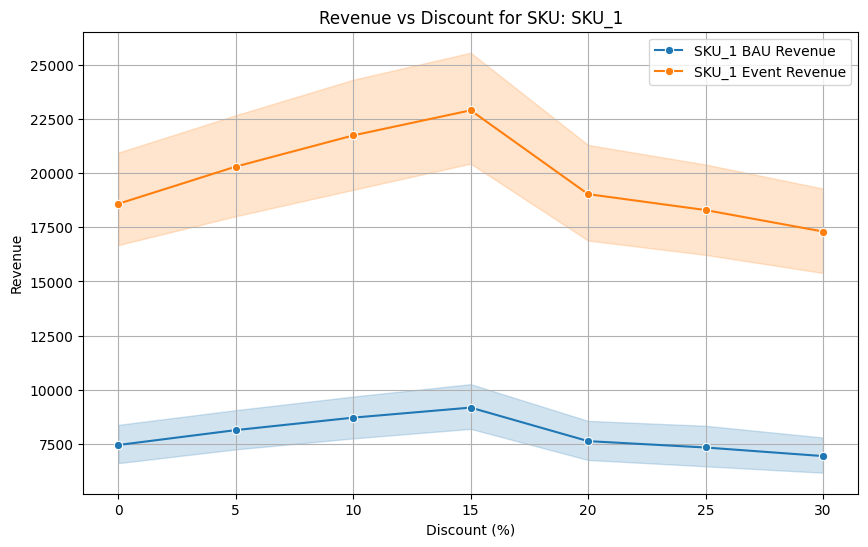

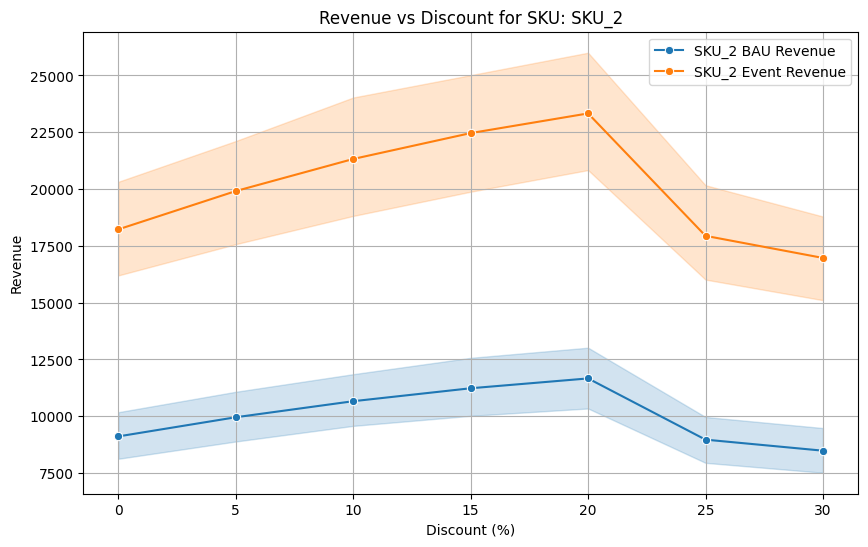

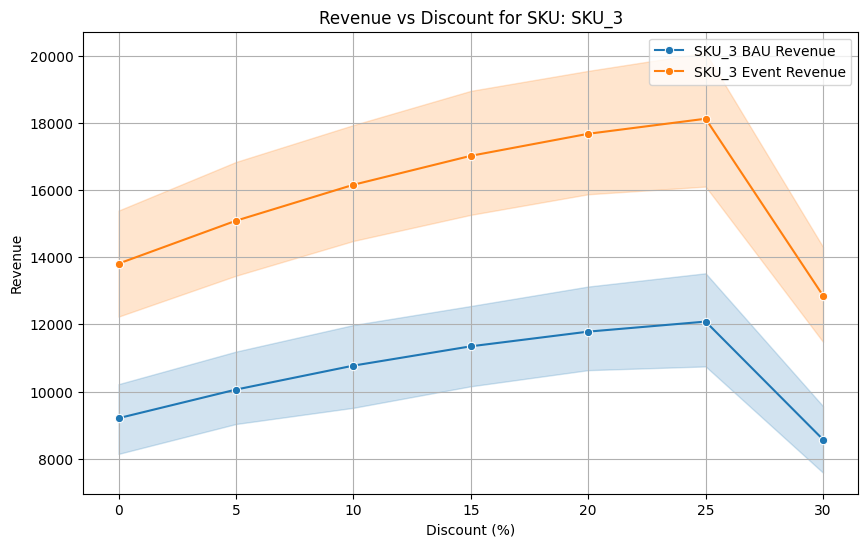

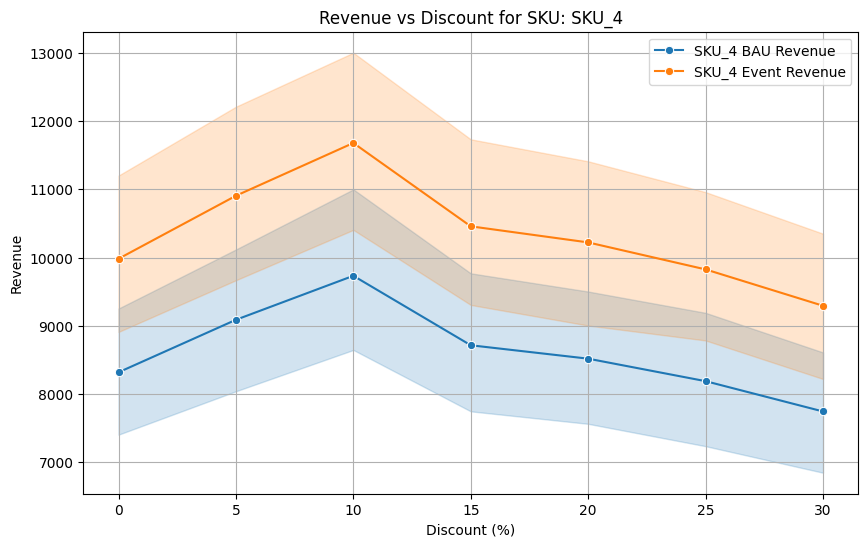

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

file_path = 'meesho_sku_sales_data_60_days.csv'
sales_data = pd.read_csv(file_path)

def demand_function(base_demand, price, base_price, elasticity, max_discount=0.20):
    discount = (base_price - price) / base_price

    if discount <= max_discount:
        demand = base_demand * (1 + discount * 3)
    else:
        demand = base_demand * (1 + discount * 3) * (1 - discount)

    return demand

def simulate_demand(base_price, discount, elasticity, base_demand, event_multiplier, is_event_day, max_discount=0.20):
    price = base_price * (1 - discount)
    demand = demand_function(base_demand, price, base_price, elasticity, max_discount)

    if is_event_day:
        demand *= event_multiplier

    return demand

discount_range = np.linspace(0, 0.30, 7)
simulation_results = []

sku_params = {
    'SKU_1': {'elasticity': -2.5, 'max_discount': 0.15, 'event_multiplier': 2.5},  # Highly elastic, low discount threshold
    'SKU_2': {'elasticity': -1.8, 'max_discount': 0.20, 'event_multiplier': 2.0},  # Moderately elastic, medium threshold
    'SKU_3': {'elasticity': -1.2, 'max_discount': 0.25, 'event_multiplier': 1.5},  # Less elastic, higher threshold
    'SKU_4': {'elasticity': -0.9, 'max_discount': 0.10, 'event_multiplier': 1.2},  # Inelastic, low threshold
    'SKU_5': {'elasticity': -1.5, 'max_discount': 0.18, 'event_multiplier': 2.2},  # Moderate elastic, mid-range
}

for index, row in sales_data.iterrows():
    sku = row['SKU']
    base_price = row['Base_Price']
    base_demand = row['Predicted_Demand']

    params = sku_params.get(sku, {'elasticity': -1.5, 'max_discount': 0.20, 'event_multiplier': 2})
    elasticity = params['elasticity']
    max_discount = params['max_discount']
    event_multiplier = params['event_multiplier']

    for discount in discount_range:

        bau_demand = simulate_demand(base_price, discount, elasticity, base_demand, 1, False, max_discount)  # BAU
        event_demand = simulate_demand(base_price, discount, elasticity, base_demand, event_multiplier, True, max_discount)  # Sales Event

        bau_revenue = bau_demand * base_price * (1 - discount)
        event_revenue = event_demand * base_price * (1 - discount)

        simulation_results.append({
            'SKU': sku,
            'Discount': discount,
            'Revenue_BAU': bau_revenue,
            'Revenue_Event': event_revenue
        })

simulation_results_df = pd.DataFrame(simulation_results)

print("Monte Carlo Simulation Results:")
print(simulation_results_df)

sample_skus = sales_data['SKU'].unique()[:5]

for sku in sample_skus:
    sku_data = simulation_results_df[simulation_results_df['SKU'] == sku]

    plt.figure(figsize=(10,6))
    sns.lineplot(x=sku_data['Discount'] * 100, y=sku_data['Revenue_BAU'], label=f'{sku} BAU Revenue', marker='o')
    sns.lineplot(x=sku_data['Discount'] * 100, y=sku_data['Revenue_Event'], label=f'{sku} Event Revenue', marker='o')

    plt.title(f'Revenue vs Discount for SKU: {sku}')
    plt.xlabel('Discount (%)')
    plt.ylabel('Revenue')
    plt.legend()
    plt.grid(True)
    plt.show()
